### Especificação do Problema

O objetivo deste trabalho é obter algumas medidas de objetos presentes em imagens digitais. 

In [1]:
from cv2 import cv2
import matplotlib.pyplot as plt 
import numpy as np

Carregando a imagem...

In [2]:
img = cv2.imread('./images/objetos3.png') 

### Transformação de Cores

Utilizamos a função cvtColor da biblioteca OpenCV para converter a imagem rgb para níveis de cinza. Essa função é utilizada para converter a imagem de um espaço de cores para outro, para o espaço de níveis de cinza indicado por cv2.COLOR_BGR2GRAY. Esse tipo de conversão pondera os canais rgb para formarem apenas uma saída, este processo é feito através da equação para determinar a luminância do rgb:



In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

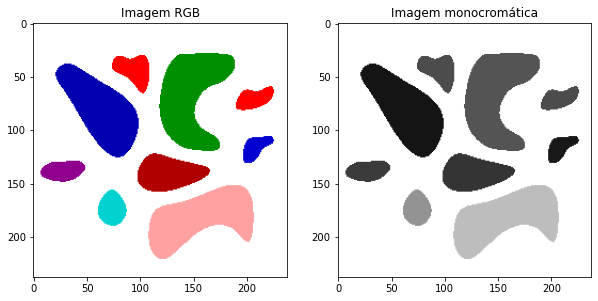

In [4]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Imagem RGB')
plt.subplot(122)
plt.imshow(gray,cmap='gray', vmin=0, vmax=255)
plt.title('Imagem monocromática')

plt.show()

### Contorno dos objetos

Para calcular o contorno dos objetos presentes na imagens primeiramente precisamos converter a imagem em tons de cinza para binária usando a função threshold do OpenCV para ficar mais simples de capturar os contornos. Pois, o contorno nada mais é do que a curva que liga todos os pontos contínuos de fronteira de mesma cor ou mesma intensidade.

Após este processo podemos aplicar a função findContours do OpenCV para que encontre os contornos da imagem, para isso ele utiliza alguns argumentos como o RETR_TREE que nada mais é do que o modo de recuperação dos contornos da imagem. Além disso, utiliza o CHAIN_APPROX_SIMPLE que é o modo de aproximação de contorno.



In [5]:
ret, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
contours, hierarquia = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

Após definir os contornos temos uma lista com cada região detectada, para mostrá-las juntas geramos uma imagem de fundo branco e após isso utilizamos a função drawContours para desenhar todas os contornos no fundo branco, para desenhar todos passamos como parâmetro -1. Para desenhar apenas um dos contornos selecionamos a posição do vetor ao invés de -1.

In [6]:
white_back = np.ones((img.shape[0], img.shape[1]))
all_contours = cv2.drawContours(white_back, contours[1:], -1, (0,255,0), 2)

In [7]:
white_back.shape

(238, 238)

Para plotar a imagem devemos multiplicar por 255, pois quando aplicamos a conversão da imagem para binário a imagem ficou com valores de 0 e 1 não aceitos pela função imshow.

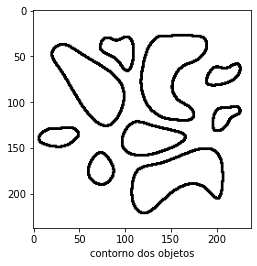

In [8]:
plt.imshow((all_contours * 255).astype(np.uint8), cmap='gray')
plt.xlabel("contorno dos objetos")
plt.show()

### Extração da propriedade dos objetos 

Para extrair as propriedades de centróide, perímetro e área devemos separar cada contorno. Para encontrarmos o centróide precisamos calcular o momento da imagem, que nada mais é do que uma média ponderada entre as intensidades dos pixels da imagem. Podemos calcular através da função moments da biblioteca OpenCV. 

Para calcular o centróide utilizamos uma relação entre os momentos da imagem:
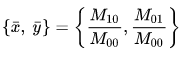

Por outro lado, para calcularmos a área utilizamos a função contourArea, no caso da imagem a área é a soma de todos os pixels do objeto. De mesmo modo, para calcular o perímetro utilizamos a função arcLength. Ambas funções da biblioteca OpenCV.

Para calcular a excentricidade (quão alongado é um contorno) existem várias formas, tanto pela proporção das distâncias entre os eixos, quanto por uma função que relaciona momentos. Escolhi fazer pela relação de momentos pois já estava utilizando antes para calcular os centros.
A função que relaciona os momentos está descrita abaixo:

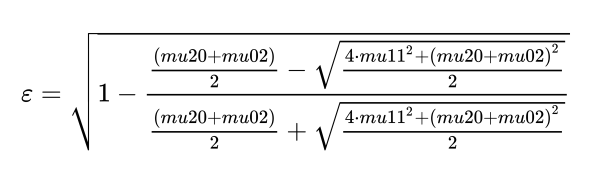


Por fim, para calcularmos a solidez (densidade) calculamos a área do objeto e dividimos pela área do fecho convexo. O valor de solidez ´e igual a 1 para um objeto sólido e menor que 1 para objetos
apresentando borda irregular ou contendo buracos.

In [9]:
def eccentricity_(moments):
    a1 = (moments['mu20'] + moments['mu02']) / 2
    a2 = np.sqrt(4 * moments['mu11'] ** 2 + (moments['mu20'] -moments['mu02']) ** 2) / 2
    ecc = np.sqrt(1 - (a1 - a2) / (a1 + a2))
    return ecc

In [10]:
aux = 0
areas = []
for contour in contours[1:]:
    
    M = cv2.moments(contour) #calculo do momento
    
    cX = int(M["m10"] / M["m00"]) #calculo da coordenada x central
    cY = int(M["m01"] / M["m00"]) #calculo da coordenada y central
    area = cv2.contourArea(contour) #calculo da área de contorno
    perimeter = cv2.arcLength(contour,True) #calculo do perímetro
    
    
    hull = cv2.convexHull(contour) #Área do fecho convexo
    hull_area = cv2.contourArea(hull) #Área do contorno
    solidity = float(area)/hull_area  #Solidez
    areas.append(area) 

    eccentricity = eccentricity_(M) #Excentricidade
    
  
    print('região {}:  centróide: {}  perímetro: {:,.6f} área: {:,.0f} excentricidade: {:,.6f} solidez: {:,.6f} '.format(aux, (cX, cY), perimeter, area, eccentricity, solidity))
    
#     Descomentar se gostar das figuras + borda realçada 
#     img = cv2.drawContours(img, contours[1:], -1, (0,255,0), 3)
    img= cv2.putText(img, str(aux), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 0, 0), 1) #adicionando labels ao centro de cada imagem, com tamanho de 0,25, fonte: FONT_HERSHEY_SIMPLEX e 1 px de largura.
    
    aux +=1

região 0:  centróide: (73, 173)  perímetro: 101.982755 área: 716 excentricidade: 0.610530 solidez: 0.980164 
região 1:  centróide: (156, 182)  perímetro: 311.078208 área: 4,067 excentricidade: 0.908225 solidez: 0.780689 
região 2:  centróide: (27, 137)  perímetro: 108.669047 área: 688 excentricidade: 0.882704 solidez: 0.972458 
região 3:  centróide: (126, 140)  perímetro: 179.781745 área: 1,762 excentricidade: 0.864278 solidez: 0.971862 
região 4:  centróide: (208, 116)  perímetro: 94.426406 área: 478 excentricidade: 0.850570 solidez: 0.925460 
região 5:  centróide: (206, 70)  perímetro: 104.911687 área: 584 excentricidade: 0.882918 solidez: 0.913928 
região 6:  centróide: (62, 80)  perímetro: 265.119838 área: 3,690 excentricidade: 0.896234 solidez: 0.978264 
região 7:  centróide: (94, 43)  perímetro: 125.639609 área: 844 excentricidade: 0.735146 solidez: 0.904558 
região 8:  centróide: (147, 68)  perímetro: 319.421354 área: 4,107 excentricidade: 0.813036 solidez: 0.754963 


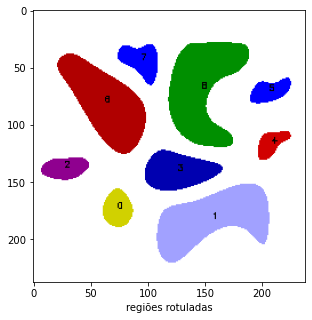

In [11]:
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.xlabel('regiões rotuladas')
plt.show()

### Histograma da área dos objetos

Separamos as áreas dos objetos de acordo com a propriedade da área:

    - objeto pequeno: área < 1500 pixels

    - objeto médio: área ≥ 1500 pixels e área < 3000 pixels

    - objeto grande: área ≥ 3000



In [12]:
areas = np.array(areas)
small = areas[areas < 1500]
medium = areas[(areas < 3000) & (areas >= 1500)]
big = areas[areas >= 3000]

print("número de regiões pequenas: {} \nnúmero de regiões médias: {} \nnúmero de regiões grandes: {}".format(len(small), len(medium), len(big)))

número de regiões pequenas: 5 
número de regiões médias: 1 
número de regiões grandes: 3


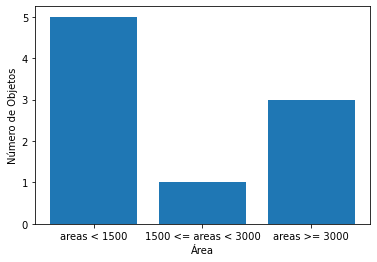

In [14]:
values = [len(small), len(medium), len(big)]
labels = ['areas < 1500', '1500 <= areas < 3000', 'areas >= 3000']
plt.figure(figsize = (6,4))
plt.bar(labels, values)
plt.xlabel("Área")
plt.ylabel("Número de Objetos")
plt.show()


### Testes Realizados

- Teste com várias imagens de formas;
- Testes de diferentes modos de implementação (sckit-image, cv2);
- Diferentes thresholds;
- Visualização dos resultados e comparação com teoria;


### Limitações

- Label fica torta, pois as formas não são totalmente preenchidas